In [22]:
# Ion Chemistry

"""
Preparation (could be written as module)
- load file with reaction and species information, inkl. stochiometry and charges etc.
- produce classes with sepcies concentration etc
- produce classes with reaction information
"""

import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from scipy.interpolate import CubicSpline, interp1d, PchipInterpolator
import import_ipynb
from organizing import pcfg
con = pcfg

class constituent():
    """
    For every constituent of the ionosphere, this class is generated to record its
    -density
    -production
    -loss
    and from that calculate the density of the new timestep.
    All these values are in the form of an array as a height profile.    
    """
    def __init__(self, c_ID, name, charge, density):
        self.c_ID = int(c_ID)
        self.name = name
        self.density = density
        self.charge = int(charge)
        self.loss = np.zeros(len(self.density))
        self.prod = np.zeros(len(self.density))
        self.dndt = np.zeros(len(self.density))
        self.Te = np.nan
        self.Tn = np.nan
        self.Tr = np.nan
    
    def log(self, density):
        raise NotImplementedError
        
    def integrate(self, prod, loss):
        self.dndt = prod - loss
        return NotImplementedError
    
    def iterate_time(self, dt):
        self.dndt = self.prod - self.loss
        self.density = self.density + self.dndt * dt
        self.density[self.density < 0] = 0
        self.prod = np.zeros(len(self.density))
        self.loss = np.zeros(len(self.density))
        return NotImplementedError('Dont use Euler for integartion.')
        #self.log(density)

        

class reaction():
    """
    Defines all parameters of a chemical reaction in the ionosphere
    
    Parameters:
    r_ID: Name of the reaction (according to Brekke of Schunk and Nagy)
        string
    r_stoch: Reaction in chemical symbols, with stochiometry
        string
    educts: constituents that go into the reaction (lefthand side of r_stoch)
        list of strings
    products: constituents that come out of the reaction (righthand side of r_stoch)
        list of strings
    r_rate_string: the reaction rate, ready to be interpreted as a equation in python (with variables)
        string
        
    Methods:
    r_rate: evaluates the reaction rate at a given temperature T
        float
    """    
    def __init__(self, ionChem_inst, r_ID,  r_name, r_stoch, educts, products, r_rate_string, all_species):
        self.r_ID = int(r_ID)
        self.r_name = r_name
        self.r_stoch = r_stoch
        self.educts = educts
        self.educts_ID = ionChem_inst.getConstituentsIDByName(self.educts)
        self.products = products
        self.products_ID = ionChem_inst.getConstituentsIDByName(self.products)
        self.r_rate_string = r_rate_string
        self.ionChem_inst = ionChem_inst
        
    def r_rate(self):
        Te = self.ionChem_inst.Te
        Tn = self.ionChem_inst.Tn
        Tr = self.ionChem_inst.Tr
        #evaluating the function and ensuring it has the dimension of z_model
        self.rr = eval(self.r_rate_string) * np.ones(self.ionChem_inst.n_heights)
        return self.rr
    
    
    

class ionChem:
    """
    Defines the ion chemistry model.
    """
    
    def __init__(self, reactions_file, z_model):
        self.z_model = z_model
        self.n_heights = len(z_model)
        self.all_species = []
        self.load(reactions_file)
        self.time = 0
        self.iteration_step = 0
        self.recording = []

    def getConstituentsIDByName(self, names):
        """
        Gets the ID from a constituents name
        """
        ids = np.array([], dtype = int)
        for name in names:
            for c in self.all_species:
                if c.name == name: ids = np.append(ids, c.c_ID)
        return ids
    
    def load(self, reactions_file):
        """
        Load config file, specifying the species and reactions to be observed
        """
        species_raw = np.array([], dtype = object)
        reactions_raw = np.array([], dtype = str)
        with open(reactions_file, 'r') as f:
            content = f.read()
            lines = [line for line in content.split('\n')]
            for line_no, line in enumerate(lines):
                if line[:14] == '--Constituents':
                    start_consprint = line_no
                if line[:11] == '--Reactions':
                    start_reactions = line_no
                    
            for line_no, line in enumerate(lines):
                if line_no > start_consprint+1 and line == '': break
                if line_no > start_consprint+1:
                    species_raw = np.append(species_raw, line)
        
            for line_no, line in enumerate(lines):
                if line_no > start_reactions+1 and line == '': break
                if line_no > start_reactions+1:
                    reactions_raw = np.append(reactions_raw, line)

        species_str = np.array([c.replace('\t', '').replace(' ', '').split(';') for c in species_raw])
        if con.print: print(species_str, '\n')
        
        
        reactions_str = np.array([r.replace('\t', '').split(';') for r in reactions_raw], dtype = object)
        if con.print: print(reactions_raw)
        if con.print: print(reactions_str)
        
        for c in species_str:
            self.all_species.append(constituent(c[1], c[0], int(c[2]), np.zeros(self.n_heights)))
            name = c[0].replace('+', 'p')
            exec(f'self.{name} = self.all_species[-1]')
            
        for ind, c in enumerate(self.all_species):
            if con.print: print(c.name, c.c_ID)
            if c.c_ID != ind: raise RuntimeError
        self.ions = [c for c in self.all_species if c.charge == 1]
        
        self.all_reactions = []
        """
        arrays:
        axis 0: reactions
        axis 1: ID, reaction rate, educts,     products
        axis 2:                    e1, ...     p1, p2, ...
        """
        for i, r in enumerate(reactions_str):
            r_ID = i
            r_name = r[0]
            r_rate_string = r[2].replace('m3s-1', '').replace(' ', '')
            r_stoch = r[1][1:]
            
            educts, products = r[1].split('=>')
            educts = educts.split(' + ')
            educts = np.char.replace(educts, ' ', '')
        
            products = products.split(' + ')
            products = np.char.replace(products, ' ', '')
            if con.print: print(r_ID, r_rate_string, educts, products)
            
            self.all_reactions.append(reaction(self, r_ID, r_name, r_stoch, educts, products, r_rate_string, self.all_species))
            exec(f'self.{r_name} = self.all_reactions[-1]')
    
    
    def assign_densities(self
                         , z_model
                         , z_msis
                         , n_o1_msis
                         , n_n2_msis
                         , n_o2_msis
                         , z_iri
                         , ne_iri        
                         , rel_o_p   
                         , rel_n_p   
                         , rel_h_p   
                         , rel_he_p  
                         , rel_o2_p  
                         , rel_no_p):
        """
        Assigns densities at the very beginning of the simulation.
        """
        

        def mix_interpolation(density, z_iri, z_model, mixing_height):
            nop_cs = CubicSpline(z_iri, density)(z_model) #produces negative electron density
            nop_exp_int_log = np.exp(interp1d(z_iri[1:], np.log(density[1:]), fill_value = 'extrapolate')(z_model)) 
            nop_mix = np.array([ *nop_exp_int_log[z_model < mixing_height], *nop_cs[z_model >= mixing_height]])
            return nop_mix
        
        ne_mix = mix_interpolation(ne_iri, z_iri, z_model, 90000)
        self.e.density   = ne_mix
        
        nop_iri = ne_iri*rel_no_p
        self.NOp.density = mix_interpolation(nop_iri, z_iri, z_model, 90000)
        
        o2p_iri = ne_iri*rel_o2_p
        self.O2p.density = mix_interpolation(o2p_iri, z_iri, z_model, 90000)
        #self.O2p.density = self.e.density*np.exp(interp1d(z_iri, np.log(rel_o2_p), fill_value='extrapolate')(z_model))

        op_iri = ne_iri*rel_o_p
        self.Op.density  = mix_interpolation(op_iri[rel_o_p > 0], z_iri[rel_o_p > 0], z_model, 150000) #[rel_o_p > 0] to avoid being tied to 0 => interpolation can produce densities larger than 0, even when rel_o_p = 0 in IRI model

        self.Np.density  = self.e.density*0
        self.N2p.density = self.e.density*0
        self.N.density   = self.e.density*0
        self.NO.density  = self.e.density*0

        self.N2.density  = np.exp(PchipInterpolator(z_msis, np.log(n_n2_msis))(z_model))
        self.O2.density  = np.exp(PchipInterpolator(z_msis, np.log(n_o2_msis))(z_model))
        self.O.density   = np.exp(PchipInterpolator(z_msis, np.log(n_o1_msis))(z_model))


        #check charge neutrality:
        if con.print:
            plt.figure()
            plt.plot(self.e.density, z_model/1e3, label = 'ne_isi_int')
            plt.plot(np.sum([c.density for c in self.all_species if c.charge ==1], axis = 0), z_model/1e3, label = 'ne_charge_neutral')
            plt.xscale('log')
            plt.xlabel('Density [m-3]')
            plt.ylabel('Altitude [km]')
            plt.title('Density profiles of e (before and after charge neutrality)')
            plt.legend()
            
            plt.figure()
            plt.plot(np.sum([c.density for c in self.all_species if c.charge ==1], axis = 0), z_model/1e3, label = 'ne_charge_neutral')
            for c in self.ions:
                plt.plot(c.density, z_model/1e3, label = 'ne_charge_neutral')
            plt.xscale('log')
            plt.xlabel('Density [m-3]')
            plt.ylabel('Altitude [km]')
            plt.title('Density profiles of e and ions after charge neutrality')
            plt.legend()
        
        self.e.density  = np.sum([c.density for c in self.all_species if c.charge ==1], axis = 0)
        
        
        if con.print:
            plt.figure()
            plt.plot(self.all_species[0].density, z_model/1e3, label='e')
            plt.plot(np.sum([i.density for i in self.all_species if i.charge == 1], axis = 0), z_model/1e3, label='p')
            plt.legend()
            plt.xscale('log')
            plt.xlabel('Density [m-3]')
            plt.ylabel('Altitude [km]')
            plt.title('Comparison e- and ion+ density')
            
            for c in self.all_species:
                plt.figure()
                plt.plot(c.density, self.z_model/1e3, label=c.name)
                plt.legend()
                plt.xscale('log')
                plt.xlabel('Density [m-3]')
                plt.ylabel('Altitude [km]')
            
            
    def assign_temperatures(self, z_iri, t_neutral, t_ion, t_e):
        """
        Assigns temperatures at teh very beginning of the simulation
        """
        self.Tn = PchipInterpolator(z_iri, t_neutral)(self.z_model)
        self.Te = PchipInterpolator(z_iri, t_e)(self.z_model)
        #self.Te = interp1d(z_iri, t_e, fill_value='extrapolate')(self.z_model)
        self.Tr = PchipInterpolator(z_iri, t_ion)(self.z_model)
        
        
    def update_timestep(self, dt):
        """
        iteration step over timeintervalls using eulers method (unused at the moment)
        #for i in range(2000):
        #    model.update_timestep(dt)
        #    #plot_snapshot(model)
        #    #if model.time%1 == 0: setup_.datadump(model)
        #    if model.iteration_step%1 == 0: 
        #        setup_.datadump(model)
        #    if model.iteration_step%1000 == 0:
        #        print(model.time)  
        """
        for r in self.all_reactions:
            #if con.print: print(r.educts, ' => ', r.products, r.r_rate_string)
            #update Te!!
            Te = 300
            rr = r.r_rate(Te)
            for e_ind in r.educts_ID: #refer to educts by index instead of name
                n = self.all_species[e_ind].density
                rr = rr*n
            for e_ind in r.educts_ID:
                self.all_species[e_ind].loss += rr
            for p_ind in r.products_ID:
                self.all_species[p_ind].prod += rr
                
        for c in self.all_species:
            c.iterate_time(dt)
        
        self.time = self.time + dt
        self.iteration_step += 1
        self.check_chargeNeutrality()
        raise RuntimeError('Dont use Euler integration!')
        
        
        """
        1. check reaction rates
            - if over threshold (1e2), treat as instantaneous (not in ODE)
        1. build ODE
            - separate independent species
            - evalueate rr
        2. solve it 
        """
        raise NotImplementedError('not yet implemented')
        for c in self.all_species:
            eff_rr = np.zeros([len(model.all_species), len(z_model)])
            for r in self.all_reactions:
                if c.c_ID in r.educts_ID:
                    if con.print:
                        print(r.r_stoch, '\n', c.name, r.educts[r.educts != c.name], '\n', c.c_ID, r.educts_ID[r.educts_ID != c.c_ID], '\n')
                    [id_other_const] = r.educts_ID[r.educts_ID != c.c_ID]
                    eff_rr[c.c_ID] = r.r_rate(300)*self.all_species[id_other_const].density
            if any(eff_rr[c.c_ID, :] > 1e2):
                filter_ = np.array(eff_rr[c.c_ID, :] > 1e2)
                
        
        
        
    def check_chargeNeutrality(self):
        """
        checks charge neutrality by adding up all charge densities, and checking if it balances to 0.
        The charge density is divided by the density for normalization.
        """
        total_charge = np.zeros(len(self.all_species[0].density))
        density_cc = np.zeros(len(self.all_species[0].density)) 
        for c in self.all_species:
            if c.charge != 0:
                total_charge += c.density * c.charge
                density_cc += c.density
        reduced_tot_charge = total_charge / density_cc
        if any(reduced_tot_charge > 1e-12):
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(reduced_tot_charge, self.z_model/1e3)
            plt.xlabel('Charge density [C m-3]')
            plt.ylabel('Altitude [km]')
            plt.title('Charge Density profile at time ' + str(self.time) + ', step: ' + str(self.iteration_step))
            raise RuntimeError('Charge neutrality violated')
        
        if con.print:
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(reduced_tot_charge, self.z_model/1e3)
            plt.xlabel('Charge density [C m-3]')
            plt.ylabel('Altitude [km]')
            plt.title('Charge Density profile')
            
    def plot_density(self):
        plt.figure()
        for c in self.all_species:
            plt.plot(c.density, self.z_model/1e3, label = c.name)
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles')
        plt.legend()
        labelLines(plt.gca().get_lines(), align = False, xvals = [c.density[-1] for c in self.all_species])
        
        
    def lossTable(self):
        """
        generates a lookup table for raction rates from a list of reactions.
        as well as a lookup table for reaction partners, such that the product a_i,j * n_i * n_j quickly can be computed
        is intended to be called everytime the temperature is updated.
        """
        self.loss_table_rr  = np.zeros([len(self.all_reactions), len(self.all_species), self.n_heights])
        self.loss_table_ind = np.zeros([len(self.all_reactions), len(self.all_species)])
        
        for r in self.all_reactions:
            i, j = r.educts_ID
            self.loss_table_rr[r.r_ID, i]  = r.r_rate()
            self.loss_table_rr[r.r_ID, j]  = r.r_rate()
            self.loss_table_ind[r.r_ID, i] = j
            self.loss_table_ind[r.r_ID, j] = i
            
     
    def prodTable(self):
        """
        generates a lookup table for raction rates from a list of reactions.
        as well as a lookup table for reaction partners, such that the product a_i,j * n_i * n_j quickly can be computed
        is intended to be called everytime the temperature is updated.
        """
        self.prod_table_rr  = np.zeros([len(self.all_reactions), len(self.all_species), self.n_heights])
        self.prod_table_ind = np.zeros([len(self.all_reactions), len(self.all_species), 2])

        for r in self.all_reactions:
            k, l = r.products_ID
            i, j = r.educts_ID

            if k == l:
                self.prod_table_rr[r.r_ID, k] = 2 * r.r_rate()
                self.prod_table_ind[r.r_ID, k, 1] = i
                self.prod_table_ind[r.r_ID, k, 0] = j
            
            else:
                self.prod_table_rr[r.r_ID, k] = r.r_rate()
                self.prod_table_rr[r.r_ID, l] = r.r_rate()
                self.prod_table_ind[r.r_ID, k, 0] = j
                self.prod_table_ind[r.r_ID, l, 0] = j
                self.prod_table_ind[r.r_ID, k, 1] = i
                self.prod_table_ind[r.r_ID, l, 1] = i
                
                
    def plot_decayTime(self):
        """
        Plots the decay time of all species, taking all reactions into account, with the reaction rate at the current temperature,
        as well as the current density of the other involved sepcies
        decay time tau_i = 1/(sum(rr_ij * n_j))
        """        
        plt.figure()

        for c in self.all_species:
            rr_species = np.zeros([len(self.all_species), self.n_heights])
            
            for r in self.all_reactions:
                if c.c_ID in r.educts_ID:
                    #if con.print: print(r.r_stoch, '\n', c.name, r.educts[r.educts != c.name], '\n', c.c_ID, r.educts_ID[r.educts_ID != c.c_ID], '\n')
                    [cid2] = r.educts_ID[r.educts_ID != c.c_ID]
                    rr_species[cid2] = r.r_rate()*self.all_species[cid2].density
                    
            decay_time = 1/np.sum(rr_species, axis = 0)
            line = plt.plot(decay_time, self.z_model/1e3, label = c.name)
            plt.text(decay_time[0], self.z_model[1]/1e3, c.name, color = line[0].get_color())
                    
        plt.xscale('log')
        plt.xlabel('Decay Time [s]')
        plt.ylabel('Altitude [km]')
        plt.show()
        #plt.legend()
    
    
    def plot_reactionRate(self):
        """
        Plots the reaction rate of all species, taking all reactions into account, with the reaction rate at the current temperature,
        as well as the current density of the other involved sepcies
        decay time tau_i = sum(rr_ij * n_j)
        """        
        plt.figure()

        for c in self.all_species:
            rr_species = np.zeros([len(self.all_species), self.n_heights])
            
            for r in self.all_reactions:
                if c.c_ID in r.educts_ID:
                    #if con.print: print(r.r_stoch, '\n', c.c_ID, r.educts_ID[r.educts_ID != c.c_ID], '\n')
                    [cid2] = r.educts_ID[r.educts_ID != c.c_ID]
                    rr_species[cid2] = r.r_rate()*self.all_species[cid2].density
                    
            line = plt.plot(np.sum(rr_species, axis = 0), self.z_model/1e3, label = c.name)
            plt.text(np.sum(rr_species, axis = 0)[0], self.z_model[1]/1e3, c.name, color = line[0].get_color())
                    
        plt.xscale('log')
        plt.xlabel('Reaction Rate * Density [s-1]')
        plt.ylabel('Altitude [km]')
        #plt.legend()
                    

In [23]:
if con.print:
    #defining file paths
    msis_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'
    iri_config  = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
    
    import loadMSIS
    import loadIRI
    %matplotlib widget
    
    #load neutroal atmopshere model
    [z_msis
     , n_o1_msis
     , n_n2_msis
     , n_o2_msis
     , mass_density
     , temp_n_msis
     , scale_height_msis] = loadMSIS.loadMSIS(msis_config)
    
    #load ionosphere model
    [z_iri     
     , ne_iri    
     , t_neutral 
     , t_ion     
     , t_e       
     , rel_o_p   
     , rel_n_p   
     , rel_h_p   
     , rel_he_p  
     , rel_o2_p  
     , rel_no_p] = loadIRI.loadIRI(iri_config)
    
    z_model = np.arange(70000, 200000, 100)
    

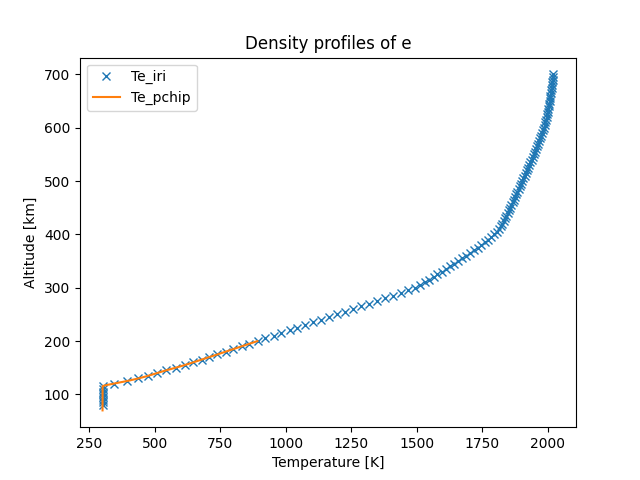

In [32]:
if con.print:
    plt.figure()
    plt.plot(t_e, z_iri/1e3, 'x', label = 'Te_iri')
    plt.plot(PchipInterpolator(z_iri, t_e)(z_model), z_model/1e3, label = 'Te_pchip')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of e')
    plt.legend()
      
        
#        self.Tn = interp1d(z_iri, t_neutral, fill_value = 'extrapolate')(self.z_model)
 #       self.Te = interp1d(z_iri, t_e, fill_value = 'extrapolate')(self.z_model)
  #      self.Tr = interp1d(z_iri, t_ion, fill_value = 'extrapolate')(self.z_model)

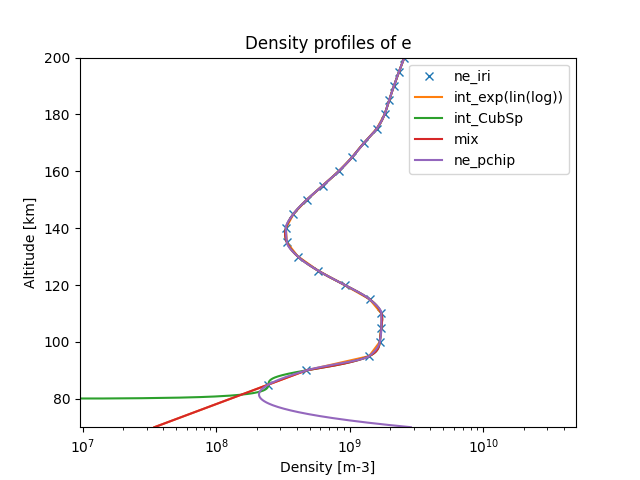

In [23]:
if con.print:
    def mix_interpolation(density, z_iri, z_model, mixing_height):
        nop_cs = CubicSpline(z_iri, density)(z_model) #produces negative electron density
        nop_exp_int_log = np.exp(interp1d(z_iri[1:], np.log(density[1:]), fill_value = 'extrapolate')(z_model)) 
        nop_mix = np.array([ *nop_exp_int_log[z_model < mixing_height], *nop_cs[z_model >= mixing_height]])
        return nop_mix
    
    
    '''
    Proper documentation in how to extrapolate densities from IRI model:
    General problem is that IRI model only has data down to 80 km, while we need to extrapolate down to 70km.
    Furthermore, IRI model says ne = 0 at 80km
    
    Electron density:
    np.exp(inter1d(..., np.log())) produces bumps in the density, discontinous in first derivative.
    CubicSpline produces negative densities below 80km
    
    Try:
    1. mix between CubicSpline (above 80km) and exp(inter1d(log)) (below 80km) => selected
    2. np.exp(CubicSpline(..., np.log(ne))) => no, behaves too jumpy
    '''
    
    ne_cs = CubicSpline(z_iri, ne_iri)(z_model) #produces negative electron density
    ne_exp_int_log = np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)) #bumps, i.e. discontnous in first derivative
    ne_exp_cs_log = np.exp(CubicSpline(z_iri[1:], np.log(ne_iri[1:]))(z_model)) #behaves too jumpy
    ne_mix = mix_interpolation(ne_iri, z_iri, z_model, 90000)
    ne_pchip = np.exp(PchipInterpolator(z_iri[1:], np.log(ne_iri[1:]))(z_model))
    
    #e
    plt.figure()
    plt.plot(ne_iri, z_iri/1e3, 'x', label = 'ne_iri')
    plt.plot(ne_exp_int_log, z_model/1e3, label = 'int_exp(lin(log))')
    plt.plot(ne_cs, z_model/1e3, label = 'int_CubSp')
    plt.plot(ne_mix, z_model/1e3, label = 'mix')
    plt.plot(ne_pchip, z_model/1e3, label = 'ne_pchip')
    #plt.plot(ne_exp_cs_log, z_model/1e3, label = 'ne_exp_cs_log')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of e')
    plt.legend()
    plt.ylim(70, 200)

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_53340/1707573798.py:37: RuntimeWarning: divide by zero encountered in log
  nop_exp_int_log = np.exp(interp1d(z_iri[1:], np.log(density[1:]), fill_value = 'extrapolate')(z_model))
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_53340/3166937781.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.exp(interp1d(z_iri[1:], np.log(rel_no_p[1:]), fill_value = 'extrapolate')(z_model))*ne_model, z_model/1e3, label = 'int_exp(lin(log)) *ne')
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_53340/3166937781.py:15: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]*rel_no_p[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')


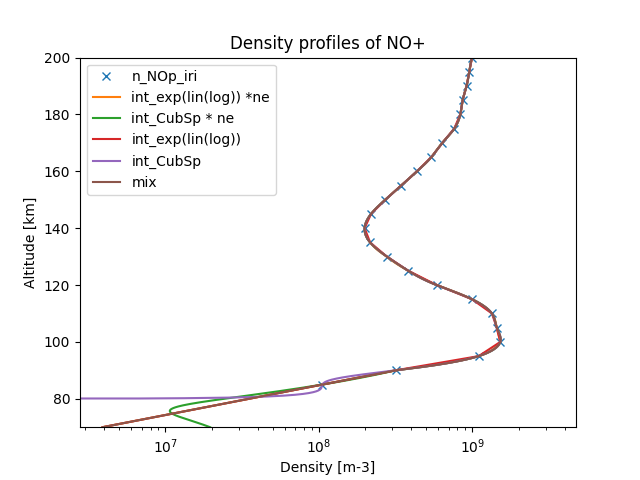

In [3]:
if con.print:
    #NO+
    '''
    np.exp(interp1d(z_iri[1:], np.log(rel_no_p[1:]) is too choppy
    '''
    ne_model = ne_mix
    
    nop_iri = ne_iri*rel_no_p
    nop_mix = mix_interpolation(nop_iri, z_iri, z_model, 90000)
    
    plt.figure()
    plt.plot(ne_iri*rel_no_p, z_iri/1e3, 'x', label = 'n_NOp_iri')
    plt.plot(np.exp(interp1d(z_iri[1:], np.log(rel_no_p[1:]), fill_value = 'extrapolate')(z_model))*ne_model, z_model/1e3, label = 'int_exp(lin(log)) *ne')
    plt.plot(CubicSpline(z_iri, rel_no_p)(z_model)*ne_model, z_model/1e3, label = 'int_CubSp * ne')
    plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]*rel_no_p[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
    plt.plot(CubicSpline(z_iri, ne_iri*rel_no_p)(z_model), z_model/1e3, label = 'int_CubSp')
    plt.plot(nop_mix, z_model/1e3, label = 'mix')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of NO+')
    plt.legend()
    plt.ylim(70, 200)

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_53340/1707573798.py:37: RuntimeWarning: divide by zero encountered in log
  nop_exp_int_log = np.exp(interp1d(z_iri[1:], np.log(density[1:]), fill_value = 'extrapolate')(z_model))


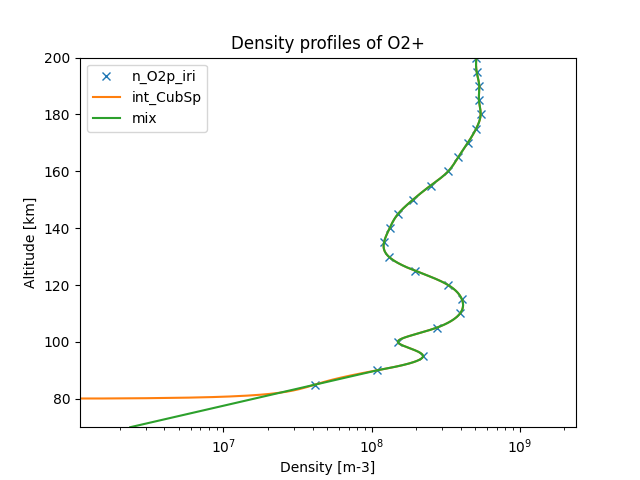

In [4]:
if con.print:
    #O2+
    '''
    '''
    ne_model = ne_mix
    
    o2p_iri = ne_iri*rel_o2_p
    o2p_mix = mix_interpolation(o2p_iri, z_iri, z_model, 90000)
    
    plt.figure()
    plt.plot(o2p_iri, z_iri/1e3, 'x', label = 'n_O2p_iri')
    #plt.plot(np.exp(interp1d(z_iri[1:], np.log(rel_o2_p[1:]), fill_value = 'extrapolate')(z_model))*ne_model, z_model/1e3, label = 'int_exp(lin(log)) *ne')
    #plt.plot(CubicSpline(z_iri, rel_o2_p)(z_model)*ne_model, z_model/1e3, label = 'int_CubSp * ne')
    #plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]*rel_o2_p[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
    #plt.plot(np.exp(CubicSpline(z_iri[1:], np.log(ne_iri[1:]*rel_o2_p[1:]))(z_model)), z_model/1e3, label = 'int_exp(CS(log))')
    plt.plot(CubicSpline(z_iri, ne_iri*rel_o2_p)(z_model), z_model/1e3, label = 'int_CubSp')
    plt.plot(o2p_mix, z_model/1e3, label = 'mix')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O2+')
    plt.legend()
    plt.ylim(70, 200)

[4.85448645e+01 4.93148689e+01 5.00970868e+01 ... 1.03529457e+09
 1.03911063e+09 1.04292261e+09]


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_53340/3479820787.py:18: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.exp(interp1d(z_iri[1:], np.log(rel_o_p[1:]), fill_value = 'extrapolate')(z_model))*ne_model, z_model/1e3, label = 'int_exp(lin(log)) *ne')
/Users/ost051/Library/Python/3.10/lib/python/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/ost051/Library/Python/3.10/lib/python/site-packages/scipy/interpolate/_interpolate.py:644: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_53340/3479820787.py:20: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]*rel_o_p[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
/Users/ost051/Library/Python/3.10/l

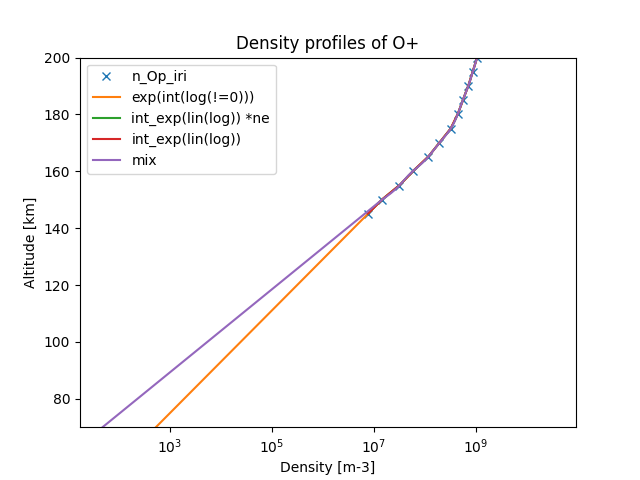

In [20]:
if con.print:
    #O+
    '''
    '''
    ne_model = ne_mix
    
    op_iri = ne_iri*rel_o_p
    #op_mix = mix_interpolation(op_iri, z_iri, z_model)
    
    
    #[rel_o_p > 0] to avoid being tied to 0 => interpolation can produce densities larger than 0, even when rel_o_p = 0 in IRI model
    op_mix = mix_interpolation(op_iri[rel_o_p > 0], z_iri[rel_o_p > 0], z_model, 150000)

    plt.figure()
    plt.plot(op_iri, z_iri/1e3, 'x', label = 'n_Op_iri')
    plt.plot(np.exp(interp1d(z_iri[rel_o_p > 0], np.log(ne_iri[rel_o_p > 0]*rel_o_p[rel_o_p > 0]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'exp(int(log(!=0)))')

    plt.plot(np.exp(interp1d(z_iri[1:], np.log(rel_o_p[1:]), fill_value = 'extrapolate')(z_model))*ne_model, z_model/1e3, label = 'int_exp(lin(log)) *ne')
        #plt.plot(CubicSpline(z_iri, rel_o_p)(z_model)*ne_model, z_model/1e3, label = 'int_CubSp * ne')
    plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]*rel_o_p[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
        #plt.plot(np.exp(CubicSpline(z_iri[1:], np.log(ne_iri[1:]*rel_o_p[1:]))(z_model)), z_model/1e3, label = 'int_exp(CS(log))')
        #plt.plot(CubicSpline(z_iri, ne_iri*rel_o_p)(z_model), z_model/1e3, label = 'int_CubSp')
    plt.plot(op_mix, z_model/1e3, label = 'mix')
    #plt.plot(interp1d(z_iri, op_iri, fill_value='extrapolate')(z_model), z_model/1e3, label = 'int1d') #produces hanging structures
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O+')
    plt.legend()
    plt.ylim(70, 200)
    
    print(op_mix)

array([5.37921086e+02, 5.44812971e+02, 5.51793156e+02, ...,
       1.03453331e+09, 1.03858300e+09, 1.04264854e+09])

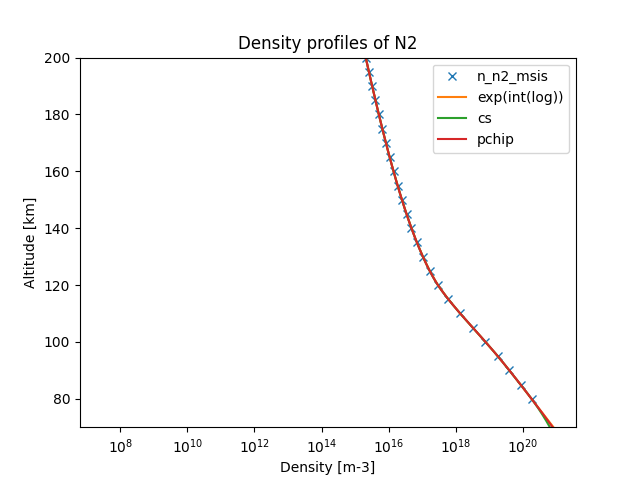

In [24]:
if con.print:
    #N2
    '''
    '''
    plt.figure()
    plt.plot(n_n2_msis, z_msis/1e3, 'x', label = 'n_n2_msis')
    plt.plot(np.exp(interp1d(z_msis, np.log(n_n2_msis), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'exp(int(log))')
    plt.plot(CubicSpline(z_msis, n_n2_msis)(z_model), z_model/1e3, label = 'cs')
    plt.plot(np.exp(PchipInterpolator(z_msis, np.log(n_n2_msis))(z_model)), z_model/1e3, label = 'pchip')


    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of N2')
    plt.legend()
    plt.ylim(70, 200)

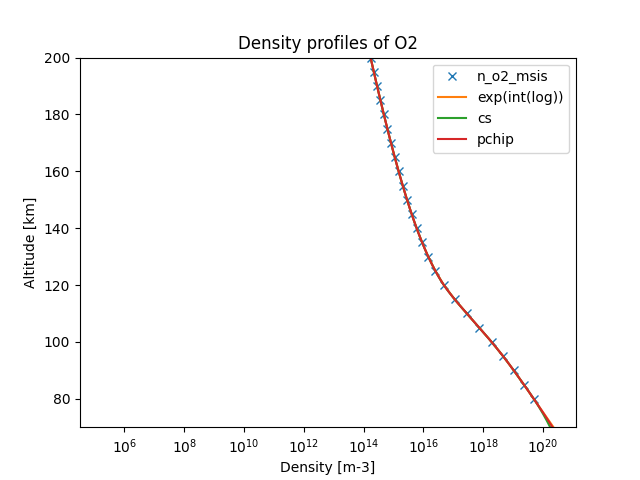

In [25]:
if con.print:
    #O2
    '''
    '''
    plt.figure()
    plt.plot(n_o2_msis, z_msis/1e3, 'x', label = 'n_o2_msis')
    plt.plot(np.exp(interp1d(z_msis, np.log(n_o2_msis), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'exp(int(log))')
    plt.plot(CubicSpline(z_msis, n_o2_msis)(z_model), z_model/1e3, label = 'cs')
    plt.plot(np.exp(PchipInterpolator(z_msis, np.log(n_o2_msis))(z_model)), z_model/1e3, label = 'pchip')

    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O2')
    plt.legend()
    plt.ylim(70, 200)

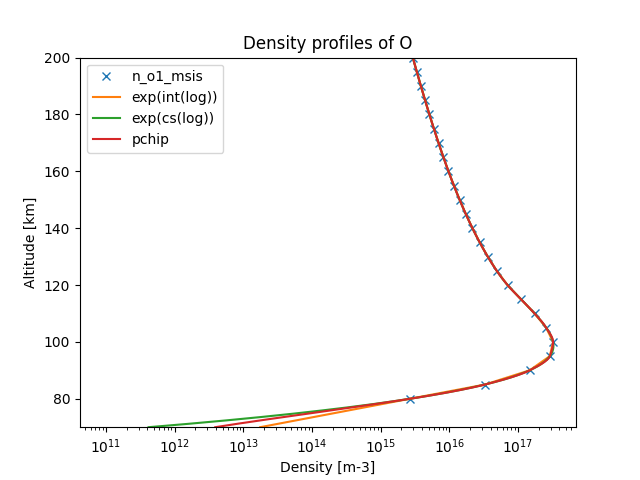

In [27]:
if con.print:
    #O
    '''
    '''
    plt.figure()
    plt.plot(n_o1_msis, z_msis/1e3, 'x', label = 'n_o1_msis')
    plt.plot(np.exp(interp1d(z_msis, np.log(n_o1_msis), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'exp(int(log))')
    #plt.plot(CubicSpline(z_msis, n_o1_msis)(z_model), z_model/1e3, label = 'cs')
    plt.plot(np.exp(CubicSpline(z_msis, np.log(n_o1_msis))(z_model)), z_model/1e3, label = 'exp(cs(log))')
    plt.plot(np.exp(PchipInterpolator(z_msis, np.log(n_o1_msis))(z_model)), z_model/1e3, label = 'pchip')

    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O')
    plt.legend()
    plt.ylim(70, 200)

In [9]:
'''
plt.figure()
plt.plot(ne_iri, z_iri/1e3, label = 'ne_iri')
plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
plt.xscale('log')
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')
plt.title('Density profiles of e')
plt.legend()

plt.figure()
plt.plot(ne_iri, z_iri/1e3, label = 'ne_iri')
plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
plt.xscale('log')
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')
plt.title('Density profiles of e')
plt.legend()

plt.figure()
plt.plot(ne_iri, z_iri/1e3, label = 'ne_iri')
plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
plt.xscale('log')
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')
plt.title('Density profiles of e')
plt.legend()


plt.figure()
plt.plot(ne_iri, z_iri/1e3, label = 'ne_iri')
plt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')
plt.xscale('log')
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')
plt.title('Density profiles of e')
plt.legend()
    

plt.figure()
plt.plot(n_o1_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
        plt.plot(np.exp(CubicSpline(z_msis, np.log(n_o1_msis))(z_model)), z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O &' + all_species[1].name)
        plt.legend()
        
    print(all_species[2].name)
    all_species[2].density = all_species[0].density*interp1d(z_iri, rel_o_p, fill_value='extrapolate')(z_model)
    if con.print:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(rel_o_p, z_iri/1e3, label = 'IRI data', marker = 'x')
        plt.plot(all_species[2].density/all_species[0].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O+')
        plt.legend()
    
    print(all_species[3].name)
    all_species[3].density = CubicSpline(z_msis, n_o2_msis)(z_model)
    if con.print:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(n_o2_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
        plt.plot(all_species[3].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O2')
        plt.legend()
        
    print(all_species[4].name)
    #all_species[4].density = all_species[0].density*CubicSpline(z_iri, rel_o2_p)(z_model)
    all_species[4].density = all_species[0].density*np.exp(interp1d(z_iri, np.log(rel_o2_p), fill_value='extrapolate')(z_model))
    if con.print:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(rel_o2_p, z_iri/1e3, label = 'IRI data', marker = 'x')
        plt.plot(all_species[4].density/all_species[0].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of O2+')
        plt.legend()
    
    print(all_species[5].name)
    all_species[5].density = all_species[0].density*0
    
    print(all_species[6].name)
    all_species[6].density = all_species[0].density*0
    
    print(all_species[7].name)
    all_species[7].density = CubicSpline(z_msis, n_n2_msis)(z_model)
    if con.print:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(n_n2_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
        plt.plot(all_species[7].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of N2')
        plt.legend()
    
    print(all_species[8].name)
    all_species[8].density = all_species[0].density*0
    
    print(all_species[9].name)
    all_species[9].density = all_species[0].density*0
    
    print(all_species[10].name)
    #all_species[10].density = all_species[0].density*CubicSpline(z_iri, rel_no_p)(z_model)
    all_species[10].density = all_species[0].density*np.exp(interp1d(z_iri, np.log(rel_no_p), fill_value='extrapolate')(z_model))
    if con.print:
        plt.figure()
        #plt.plot(alt_dens, z_model/1e3, label = 'interp_old')
        plt.plot(rel_no_p, z_iri/1e3, label = 'IRI data', marker = 'x')
        plt.plot(all_species[10].density/all_species[0].density, z_model/1e3, label = 'interp')
        plt.xscale('log')
        plt.xlabel('Density [m-3]')
        plt.ylabel('Altitude [km]')
        plt.title('Density profiles of NO+')
        plt.legend()
        
'''

"\nplt.figure()\nplt.plot(ne_iri, z_iri/1e3, label = 'ne_iri')\nplt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')\nplt.xscale('log')\nplt.xlabel('Density [m-3]')\nplt.ylabel('Altitude [km]')\nplt.title('Density profiles of e')\nplt.legend()\n\nplt.figure()\nplt.plot(ne_iri, z_iri/1e3, label = 'ne_iri')\nplt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')\nplt.xscale('log')\nplt.xlabel('Density [m-3]')\nplt.ylabel('Altitude [km]')\nplt.title('Density profiles of e')\nplt.legend()\n\nplt.figure()\nplt.plot(ne_iri, z_iri/1e3, label = 'ne_iri')\nplt.plot(np.exp(interp1d(z_iri[1:], np.log(ne_iri[1:]), fill_value = 'extrapolate')(z_model)), z_model/1e3, label = 'int_exp(lin(log))')\nplt.xscale('log')\nplt.xlabel('Density [m-3]')\nplt.ylabel('Altitude [km]')\nplt.title('Density profiles of e')\nplt.legend()\n\n\nplt.figure(